In [ ]:
"""
Modelling Notebook.
We will build 2 models to predict taxi demand per hour.
"""

'\nModelling Notebook.\nWe will build 2 models to predict taxi demand per hour\n'

In [ ]:
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.stat import ChiSquareTest
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd

In [32]:
# Create spark session
spark = (
    SparkSession.builder.appName("Modelling")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "America/New_York")
    .config("spark.driver.memory", "8g")
    .config("spark.executor.memory", "16g")
    .getOrCreate()
)

## Import Data & Prepare 

In [33]:
# Read in dataset
DIR = "../data/analysis"
final_sdf = spark.read.parquet(DIR)

In [34]:
final_sdf.printSchema()

root
 |-- LocationID: long (nullable = true)
 |-- pickup_datetime_hour: timestamp (nullable = true)
 |-- trips: long (nullable = true)
 |-- total_fare_amount: double (nullable = true)
 |-- total_amount_sum: double (nullable = true)
 |-- median_total_amount: double (nullable = true)
 |-- mean_total_amount: double (nullable = true)
 |-- median_trip_distance: double (nullable = true)
 |-- mean_trip_distance: double (nullable = true)
 |-- median_trip_duration: double (nullable = true)
 |-- mean_trip_duration: double (nullable = true)
 |-- avg_passenger_count: double (nullable = true)
 |-- total_tip_amount: double (nullable = true)
 |-- total_tolls_amount: double (nullable = true)
 |-- total_extra: double (nullable = true)
 |-- total_improvement_surcharge: double (nullable = true)
 |-- total_mta_tax: double (nullable = true)
 |-- pct_within_borough_trip: double (nullable = true)
 |-- is_weekend: boolean (nullable = true)
 |-- season: string (nullable = true)
 |-- quarter: integer (nullable 

### Drop reduncant and features derived from the hour we are counting

We do not want data leakage

In [35]:
redundant = [
    "LocationID",
    "BoroName",
    "datetime_hour",
    "pickup_datetime_hour",
    "timestamp",
    "georeference",
    "total_fare_amount",
    "total_amount_sum",
    "median_total_amount",
    "mean_total_amount",
    "median_trip_distance",
    "mean_trip_distance",
    "median_trip_duration",
    "mean_trip_duration",
    "avg_passenger_count",
    "total_tip_amount",
    "total_tolls_amount",
    "total_extra",
    "total_improvement_surcharge",
    "total_mta_tax",
    "pct_within_borough_trip",
    "hourly_ridership",
    "taxi_subway_ratio",
    "median_revenue_per_minute",
]


final_sdf = final_sdf.drop(*redundant)

In [36]:
final_sdf.printSchema()

root
 |-- trips: long (nullable = true)
 |-- is_weekend: boolean (nullable = true)
 |-- season: string (nullable = true)
 |-- quarter: integer (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- week_of_year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- PUBorough: string (nullable = true)
 |-- zone: string (nullable = true)
 |-- apparent_temperature: double (nullable = true)
 |-- cloud_cover: long (nullable = true)
 |-- direct_radiation: double (nullable = true)
 |-- is_day: long (nullable = true)
 |-- precipitation: double (nullable = true)
 |-- rain: double (nullable = true)
 |-- relative_humidity_2m: long (nullable = true)
 |-- shortwave_radiation: double (nullable = true)
 |-- snow_depth: double (nullable = true)
 |-- snowfall: double (nullable = true)
 |-- sunshine_duration: double (nullable = true)
 |-- surface_pressure: double (nullable = true)
 |-- temperature_2m: double (nullable = true)
 |-- we

In [37]:
categorical_cols = [
    "zone",
    "PUBorough",
    "season",
    "quarter",
    "pickup_hour",
    "day_of_week",
    "month",
    "week_of_year",
    "humidity_level",
    "weather_code",
    "is_day",
    "is_clear",
    "is_cloudy",
    "is_rain",
    "is_snow",
    "is_thunderstorm",
    "is_extreme_heat",
    "is_extreme_cold",
    "is_windy",
    "is_weekend",
]

#### Check we haven't missed any nulls

In [38]:
final_sdf.count()

2288448

In [39]:
final_sdf = final_sdf.dropna()

In [40]:
final_sdf.count()

2288448

We have no nulls so our data can be passed into the models

#### Feature Selection

In [41]:
# Select numeric features for MI (exclude target and categorical)
exclude_cols = set(categorical_cols + ["trips"])
numeric_cols = [
    c
    for c, t in final_sdf.dtypes
    if t in ("double", "int", "float", "bigint") and c not in exclude_cols
]

In [42]:
# Only use categorical features for ChiSquareTest
categorical_mi_cols = [
    c for c in categorical_cols if final_sdf.select(c).distinct().count() < 100
]

# Cast boolean categorical columns to integer
for c in categorical_cols:
    if dict(final_sdf.dtypes)[c] == "boolean":
        final_sdf = final_sdf.withColumn(c, col(c).cast("int"))

# Index categorical columns for ChiSquareTest
cat_indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid="keep")
    for col in categorical_mi_cols
]
cat_pipeline = Pipeline(stages=cat_indexers)
cat_indexed_df = cat_pipeline.fit(final_sdf).transform(final_sdf)

# Assemble indexed categorical features for ChiSquareTest
assembler = VectorAssembler(
    inputCols=[f"{col}_idx" for col in categorical_mi_cols], outputCol="features_vec"
)
# Transform the DataFrame to include the features vector
mi_df = assembler.transform(
    cat_indexed_df.select(*[f"{col}_idx" for col in categorical_mi_cols], "trips")
)

# ChiSquareTest for categorical features only
chi_sq_result = ChiSquareTest.test(mi_df, "features_vec", "trips").head()
mi_scores = list(zip(categorical_mi_cols, chi_sq_result.pValues))


#### Remove uncorrelated features

Show features with high p value

In [43]:
print("Features with high p values:")
for column, p in mi_scores:
    if p >= 0.05:
        print(f" - {column}: {p:.4f}")

Features with high p values:
 - is_thunderstorm: 1.0000


Select and encode

In [44]:
# Select categorical features with lowest p-values (highest test statistic values)
selected_cat_features = [f for f, p in mi_scores if p < 0.05]

# Index and encode only the selected categorical features
selected_indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid="keep")
    for col in selected_cat_features
]
selected_encoders = [
    OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_ohe")
    for col in selected_cat_features
]

cat_pipe = Pipeline(stages=selected_indexers + selected_encoders)
final_sdf = cat_pipe.fit(final_sdf).transform(final_sdf)

# Now you can assemble features as before
feature_cols = [f"{col}_ohe" for col in selected_cat_features] + numeric_cols
final_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

In [45]:
feature_cols

['PUBorough_ohe',
 'season_ohe',
 'quarter_ohe',
 'pickup_hour_ohe',
 'day_of_week_ohe',
 'month_ohe',
 'week_of_year_ohe',
 'humidity_level_ohe',
 'weather_code_ohe',
 'is_day_ohe',
 'is_clear_ohe',
 'is_cloudy_ohe',
 'is_rain_ohe',
 'is_snow_ohe',
 'is_extreme_heat_ohe',
 'is_extreme_cold_ohe',
 'is_windy_ohe',
 'is_weekend_ohe',
 'apparent_temperature',
 'cloud_cover',
 'direct_radiation',
 'precipitation',
 'rain',
 'relative_humidity_2m',
 'shortwave_radiation',
 'snow_depth',
 'snowfall',
 'sunshine_duration',
 'surface_pressure',
 'temperature_2m',
 'wind_gusts_10m',
 'wind_speed_10m',
 'precip_intensity',
 'trips_lag1',
 'trips_lag2',
 'trips_lag3',
 'trips_lag24',
 'trips_lag168',
 'trips_avg3',
 'trips_avg24',
 'trips_avg168',
 'total_fare_amount_lag1',
 'total_fare_amount_lag2',
 'total_fare_amount_lag3',
 'total_fare_amount_lag24',
 'total_fare_amount_lag168',
 'total_fare_amount_avg3',
 'total_fare_amount_avg24',
 'total_fare_amount_avg168',
 'total_amount_sum_lag1',
 'tot

## Poisson GLM

Note: error values may be different from report due to the variability in the modelling process. 

In [46]:
# Split data by month
train_df = final_sdf.filter(col("month").between(1, 8))
val_df = final_sdf.filter(col("month").between(9, 10))
test_df = final_sdf.filter(col("month").between(11, 12))

# Assemble features for each split
train_model_df = final_assembler.transform(train_df)
val_model_df = final_assembler.transform(val_df)
test_model_df = final_assembler.transform(test_df)


In [47]:
train_df.count()
train_model_df.count()

1528155

In [48]:
# Create glm, with regularisation to avoid overfitting (spark only uses L2 ridge regression)
glm = GeneralizedLinearRegression(
    featuresCol="features",
    labelCol="trips",
    family="poisson",
    link="log",  
    regParam=0.01,         
)

# Fit glm
glm_model = glm.fit(train_model_df)

# Get predictions
pois_val_pred = glm_model.transform(val_model_df)

# Evaluate on validation set
evaluator = RegressionEvaluator(
    labelCol="trips", predictionCol="prediction", metricName="rmse"
)
evaluator_r2 = RegressionEvaluator(labelCol="trips", predictionCol="prediction", metricName="r2")
r2_val = evaluator_r2.evaluate(pois_val_pred)
print(f"Validation R^2: {r2_val:.3f}")
pois_val_rmse = evaluator.evaluate(pois_val_pred)
print(f"Validation RMSE (original scale): {pois_val_rmse:.2f}")


25/08/31 00:31:08 WARN Instrumentation: [5db31189] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
25/08/31 00:31:31 WARN Instrumentation: [5db31189] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
25/08/31 00:31:52 WARN Instrumentation: [5db31189] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
25/08/31 00:32:13 WARN Instrumentation: [5db31189] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


25/08/31 00:32:34 WARN Instrumentation: [5db31189] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
25/08/31 00:32:58 WARN Instrumentation: [5db31189] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
25/08/31 00:33:20 WARN Instrumentation: [5db31189] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
25/08/31 00:33:44 WARN Instrumentation: [5db31189] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
25/08/31 00:34:06 WARN Instrumentation: [5db31189] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
25/08/31 00:34:32 WARN Instrumentation: [5db31189] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
25/08/31 00:34:55 WARN Instrumentation: [5db31189] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton 

Validation R^2: 0.789


Validation RMSE (original scale): 24.95


In [52]:
# Retrain on eval + train portions
trainval_df = train_df.union(val_df)
trainval_model_df = final_assembler.transform(trainval_df)

# Fit final model
glm_model_final = glm.fit(trainval_model_df)

# Get predictions
pois_test_pred_final = glm_model_final.transform(test_model_df)

# Evaluate RMSE
pois_test_rmse_final = evaluator.evaluate(pois_test_pred_final)
print(f"Final Test RMSE (Poisson GLM, retrained): {pois_test_rmse_final:.2f}")

# R^2
pois_test_r2_final = evaluator.evaluate(pois_test_pred_final, {evaluator.metricName: "r2"})
print(f"Final Test R^2 (Poisson GLM, retrained): {pois_test_r2_final:.2f}")


25/08/31 01:45:29 WARN Instrumentation: [79a928d4] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
25/08/31 01:45:56 WARN Instrumentation: [79a928d4] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
25/08/31 01:46:23 WARN Instrumentation: [79a928d4] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
25/08/31 01:46:50 WARN Instrumentation: [79a928d4] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
25/08/31 01:47:17 WARN Instrumentation: [79a928d4] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
25/08/31 01:47:44 WARN Instrumentation: [79a928d4] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
25/08/31 01:48:11 WARN Instrumentation: [79a928d4] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton 

Final Test RMSE (Poisson GLM, retrained): 25.93


25/08/31 01:57:13 WARN DAGScheduler: Broadcasting large task binary with size 1186.0 KiB


Final Test R^2 (Poisson GLM, retrained): 0.77


25/08/31 01:57:24 WARN DAGScheduler: Broadcasting large task binary with size 1187.1 KiB


## Gradient Boosted Trees

In [22]:
from pyspark.ml.regression import GBTRegressor

# Create GBT
gbt = GBTRegressor(featuresCol="features", labelCol="trips", maxIter=100, maxDepth=5)

# Fit our model
gbt_model = gbt.fit(train_model_df)

# Get predictions
gbt_val_pred = gbt_model.transform(val_model_df)

# Evaluate on validation and test set
evaluator = RegressionEvaluator(
    labelCol="trips", predictionCol="prediction", metricName="rmse"
)
evaluator_r2 = RegressionEvaluator(labelCol="trips", predictionCol="prediction", metricName="r2")
r2_val = evaluator_r2.evaluate(gbt_val_pred)
print(f"Validation R^2: {r2_val:.3f}")
gbt_val_rmse = evaluator.evaluate(gbt_val_pred)
print(f"GBT Validation RMSE: {gbt_val_rmse:.2f}")

25/08/30 22:21:56 WARN DAGScheduler: Broadcasting large task binary with size 1002.2 KiB
25/08/30 22:21:57 WARN DAGScheduler: Broadcasting large task binary with size 1002.7 KiB
25/08/30 22:21:57 WARN DAGScheduler: Broadcasting large task binary with size 1003.3 KiB
25/08/30 22:21:57 WARN DAGScheduler: Broadcasting large task binary with size 1004.5 KiB
25/08/30 22:21:58 WARN DAGScheduler: Broadcasting large task binary with size 1006.9 KiB
25/08/30 22:21:58 WARN DAGScheduler: Broadcasting large task binary with size 1009.8 KiB
25/08/30 22:21:58 WARN DAGScheduler: Broadcasting large task binary with size 1010.3 KiB
25/08/30 22:21:59 WARN DAGScheduler: Broadcasting large task binary with size 1010.8 KiB
25/08/30 22:21:59 WARN DAGScheduler: Broadcasting large task binary with size 1012.1 KiB
25/08/30 22:21:59 WARN DAGScheduler: Broadcasting large task binary with size 1014.4 KiB
25/08/30 22:22:00 WARN DAGScheduler: Broadcasting large task binary with size 1017.3 KiB
25/08/30 22:22:00 WAR

Validation R^2: 0.960


GBT Validation RMSE: 10.92


In [51]:
# Retrain on train+val, evaluate on test
# Fit final model
gbt_model_final = gbt.fit(trainval_model_df)
# Get predictions
gbt_test_pred_final = gbt_model_final.transform(test_model_df)
# Evaluate on test set
gbt_test_rmse_final = evaluator.evaluate(gbt_test_pred_final)
print(f"Final Test RMSE (GBT, retrained): {gbt_test_rmse_final:.2f}")
# GBT test R^2
gbt_test_r2_final = evaluator.evaluate(gbt_test_pred_final, {evaluator.metricName: "r2"})
print(f"Final Test R^2 (GBT, retrained): {gbt_test_r2_final:.2f}")

25/08/31 01:25:04 WARN DAGScheduler: Broadcasting large task binary with size 1001.7 KiB
25/08/31 01:25:04 WARN DAGScheduler: Broadcasting large task binary with size 1004.7 KiB
25/08/31 01:25:05 WARN DAGScheduler: Broadcasting large task binary with size 1005.2 KiB
25/08/31 01:25:05 WARN DAGScheduler: Broadcasting large task binary with size 1005.7 KiB
25/08/31 01:25:05 WARN DAGScheduler: Broadcasting large task binary with size 1006.9 KiB
25/08/31 01:25:06 WARN DAGScheduler: Broadcasting large task binary with size 1009.3 KiB
25/08/31 01:25:06 WARN DAGScheduler: Broadcasting large task binary with size 1012.1 KiB
25/08/31 01:25:07 WARN DAGScheduler: Broadcasting large task binary with size 1012.6 KiB
25/08/31 01:25:07 WARN DAGScheduler: Broadcasting large task binary with size 1013.2 KiB
25/08/31 01:25:08 WARN DAGScheduler: Broadcasting large task binary with size 1014.4 KiB
25/08/31 01:25:08 WARN DAGScheduler: Broadcasting large task binary with size 1016.7 KiB
25/08/31 01:25:09 WAR

Final Test RMSE (GBT, retrained): 11.76


Final Test R^2 (GBT, retrained): 0.95


## Performance Analysis 

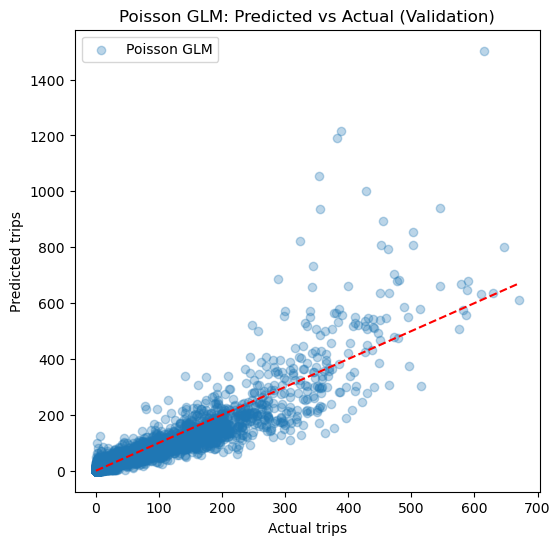

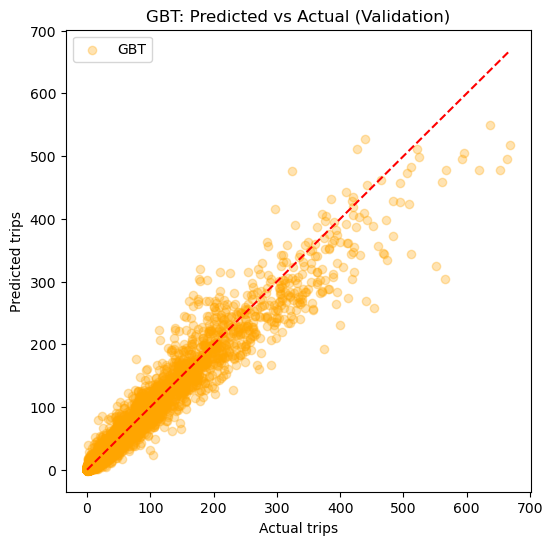

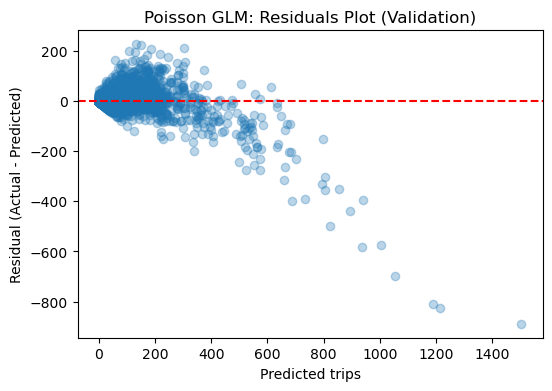

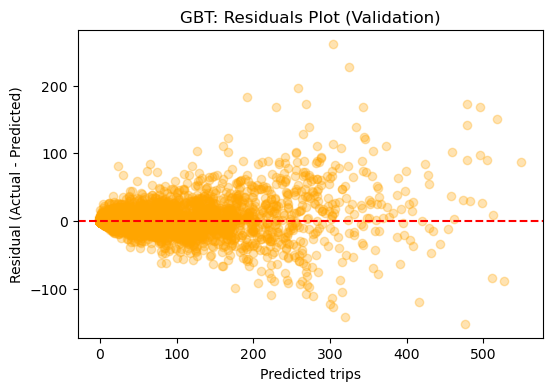

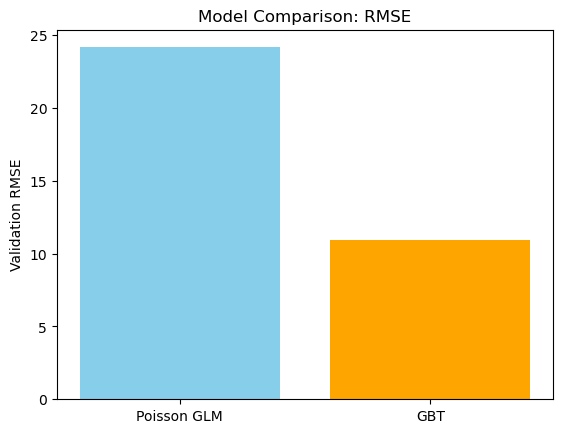

In [24]:
# Predicted vs Actual for Poisson GLM 
pois_sample = (
    pois_val_pred.select("trips", "prediction").sample(False, 0.05, seed=1462472).toPandas()
)
plt.figure(figsize=(6, 6))
plt.scatter(
    pois_sample["trips"], pois_sample["prediction"], alpha=0.3, label="Poisson GLM"
)
plt.plot(
    [pois_sample["trips"].min(), pois_sample["trips"].max()],
    [pois_sample["trips"].min(), pois_sample["trips"].max()],
    "r--",
)
plt.xlabel("Actual trips")
plt.ylabel("Predicted trips")
plt.title("Poisson GLM: Predicted vs Actual (Validation)")
plt.legend()
plt.show()

# Predicted vs Actual for GBT 
gbt_sample = (
    gbt_val_pred.select("trips", "prediction").sample(False, 0.05, seed=1462474).toPandas()
)
plt.figure(figsize=(6, 6))
plt.scatter(
    gbt_sample["trips"],
    gbt_sample["prediction"],
    alpha=0.3,
    color="orange",
    label="GBT",
)
plt.plot(
    [gbt_sample["trips"].min(), gbt_sample["trips"].max()],
    [gbt_sample["trips"].min(), gbt_sample["trips"].max()],
    "r--",
)
plt.xlabel("Actual trips")
plt.ylabel("Predicted trips")
plt.title("GBT: Predicted vs Actual (Validation)")
plt.legend()
plt.show()

# Residuals Plot for Poisson GLM 
pois_sample["residual"] = pois_sample["trips"] - pois_sample["prediction"]
plt.figure(figsize=(6, 4))
plt.scatter(pois_sample["prediction"], pois_sample["residual"], alpha=0.3)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted trips")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Poisson GLM: Residuals Plot (Validation)")
plt.show()

# Residuals Plot for GBT
gbt_sample["residual"] = gbt_sample["trips"] - gbt_sample["prediction"]
plt.figure(figsize=(6, 4))
plt.scatter(gbt_sample["prediction"], gbt_sample["residual"], alpha=0.3, color="orange")
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted trips")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("GBT: Residuals Plot (Validation)")
plt.show()

# RMSE Bar Chartb
models = ["Poisson GLM", "GBT"]
rmse = [pois_val_rmse, gbt_val_rmse]
plt.bar(models, rmse, color=["skyblue", "orange"])
plt.ylabel("Validation RMSE")
plt.title("Model Comparison: RMSE")
plt.show()

Test data performance plots

25/08/30 22:27:54 WARN DAGScheduler: Broadcasting large task binary with size 1178.7 KiB


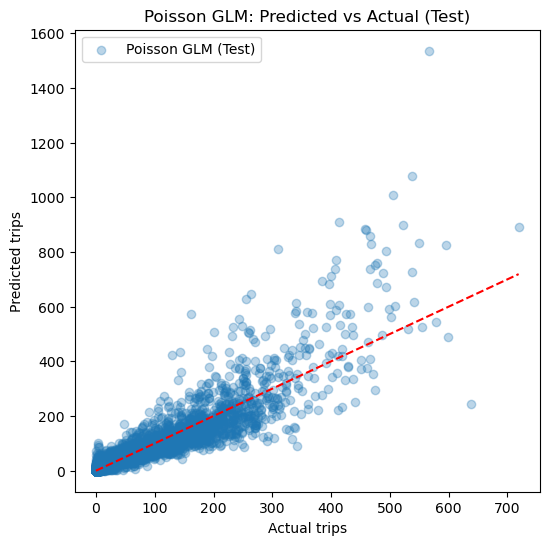

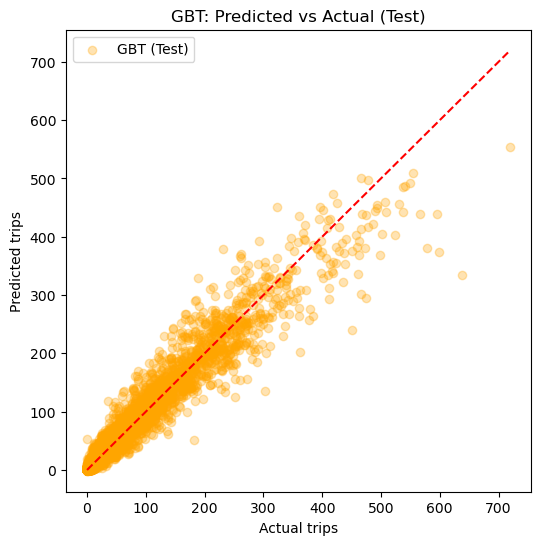

In [25]:
# Sample once from the test set
test_sample = test_df.sample(False, 0.05, seed=1462474)

# Get predictions for both models on the same sample
pois_test_sample = glm_model_final.transform(final_assembler.transform(test_sample)).select("trips", "prediction").toPandas()
gbt_test_sample = gbt_model_final.transform(final_assembler.transform(test_sample)).select("trips", "prediction").toPandas()


# Poisson GLM: Predicted vs Actual (Test)
plt.figure(figsize=(6, 6))
plt.scatter(pois_test_sample["trips"], pois_test_sample["prediction"], alpha=0.3, label="Poisson GLM (Test)")
plt.plot(
    [pois_test_sample["trips"].min(), pois_test_sample["trips"].max()],
    [pois_test_sample["trips"].min(), pois_test_sample["trips"].max()],
    "r--",
)
plt.xlabel("Actual trips")
plt.ylabel("Predicted trips")
plt.title("Poisson GLM: Predicted vs Actual (Test)")
plt.legend()
plt.show()

# GBT: Predicted vs Actual (Test)
plt.figure(figsize=(6, 6))
plt.scatter(gbt_test_sample["trips"], gbt_test_sample["prediction"], alpha=0.3, color="orange", label="GBT (Test)")
plt.plot(
    [gbt_test_sample["trips"].min(), gbt_test_sample["trips"].max()],
    [gbt_test_sample["trips"].min(), gbt_test_sample["trips"].max()],
    "r--",
)
plt.xlabel("Actual trips")
plt.ylabel("Predicted trips")
plt.title("GBT: Predicted vs Actual (Test)")
plt.legend()
plt.show()

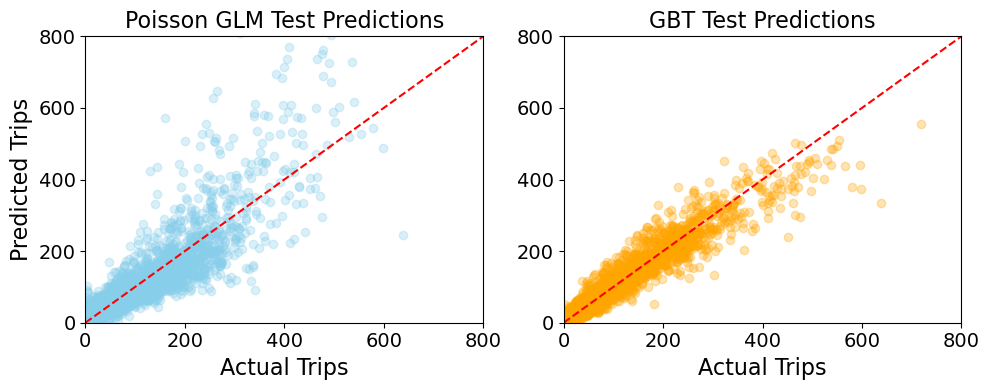

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Set zoomed-in axis limits
x_min, x_max = 0, 800
y_min, y_max = 0, 800

# Plot Poisson
ax1.scatter(pois_test_sample["trips"], pois_test_sample["prediction"], alpha=0.3, color="skyblue")
ax1.plot([x_min, x_max], [y_min, y_max], "r--")
# Large axis labels
ax1.set_title("Poisson GLM Test Predictions", fontsize=16)
ax1.set_xlabel("Actual Trips", fontsize=16)
ax1.set_ylabel("Predicted Trips", fontsize=16)
# Constrain size to show most data
ax1.set_xlim(x_min, x_max)
ax1.set_ylim(y_min, y_max)
ax1.tick_params(axis='both', labelsize=14)

# Plot GBT
ax2.scatter(gbt_test_sample["trips"], gbt_test_sample["prediction"], alpha=0.3, color="orange")
ax2.plot([x_min, x_max], [y_min, y_max], "r--")
ax2.set_title("GBT Test Predictions", fontsize=16)
ax2.set_xlabel("Actual Trips", fontsize=16)
ax2.set_xlim(x_min, x_max)
ax2.set_ylim(y_min, y_max)
ax2.tick_params(axis='both', labelsize=14)

plt.tight_layout()

In [27]:
spark.stop()